# Visualization of the Covid-19 data

There are already several dashboards out where one can compare the number of Covid-19 cases in each countries or their fatality rates, like [this one by the John Hopkins University](https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6)
or [this one for German cases in particular](https://experience.arcgis.com/experience/478220a4c454480e823b17327b2bf1d4) or [these interactive graphics of the ZEIT newspaper](https://www.zeit.de/wissen/gesundheit/2020-03/coronavirus-deutschland-infektionen-faelle-verbreitung-epidemie-karte). The goal of this Notebook is not to give more precise data than them, or present the data in a visually more appealing way. Others are better at this than I am. Instead the goal is to make the data easier explorable by creating a iPython-Notebook that does the first steps of the analysis, like obtaining the data and cleaning it, for you and then equips you with some tools to visualize this data the way _you_ want to look at it, and not the way some journalist decides is the best way too look at it. This includes tools to plot the exponent of 
the fit with an exponential to the data of only a few days or to plot the case fatality rates as a function of time.
 
## Contents:
1. [Preparation: Imports and Settings](#preparation)
2. [Data acquisition](#data_acquisition)
3. [Data preparation](#data_preparation)
4. [Preparing the tools](#preparing_the_tools)
5. [Data Analysis](#data_analysis)

The impatient folks that just want to see results and are not interested in how I got them may just skip forward to [Section 5: Data Analysis](#data_analysis). There will be a "what happened previously" paragraph explaining the thins neccesary to understand the results and to even play a bit with them.

## Further ideas:
Clearly, this analysis is by far not exhaustive. Here are some ideas what else could be done:

 - Improve the `rollingcasefatality` by finding out by how much one has to shift the dead cases against the active cases to get good estimates of the case fatalities. This could be done by using the data for China and trying to make the death and active curves as similar as possible by shifting and scaling.
 - Play around with different ways to compute the discrete derivatives by convolution with derivatives of gaussians, Savitzky-Golay filters etc.
 - Label distinctive points in the plots with the real life events that caused them.
 - Obtain data for the total populations of all countries to get per-Capita infection rates.
 - calculate the daily growth rate
 - You tell me!

<a id='preparation'></a>

## Preparation: Imports and Settings

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
import requests
from itertools import product

In [2]:
font = {"family" : "DejaVu Sans",
        "weight" : "normal",
        "size"   : 12}

plt.matplotlib.rc("font", **font)

<a id='data_acquisition'></a>

## Data acquisition
Download the data from the [Github repository](https://github.com/CSSEGISandData/COVID-19) of the Johns Hopkins University. This repository is updated daily at 23:59 UTC so running this cell once a day is enough.

In [3]:
confirmed_cases = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")
recovered_cases = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv")
dead_cases = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")

and save them as-is so we don't need to download them again every time we restart the notebook on the same day

In [4]:
confirmed_cases.to_pickle("confirmed_cases.zip")
recovered_cases.to_pickle("recovered_cases.zip")
dead_cases.to_pickle("dead_cases.zip")

And here is where we can load them again, if we need to.

In [27]:
confirmed_cases = pd.read_pickle("confirmed_cases.zip")
dead_cases = pd.read_pickle("dead_cases.zip")
recovered_cases = pd.read_pickle("recovered_cases.zip")

<a id='data_preparation'></a>

## Data preparation

Make the country name the index of the data, because that is probably the way we mostly wan't too look at it

In [5]:
confirmed_cases.set_index("Country/Region", inplace=True)
recovered_cases.set_index("Country/Region", inplace=True)
dead_cases.set_index("Country/Region", inplace=True)

Some countries are further subdivided by provinces. We are not interested in that, so we sum all provinces up there to get one column per country

In [6]:
for dataframe in [confirmed_cases, recovered_cases, dead_cases]:
    for country in dataframe.index:
        if isinstance(dataframe.loc[country], pd.DataFrame): 
            cumulative = dataframe.loc[country].sum()
            cumulative.rename(country, inplace=True)
            cumulative["Province/State"] = np.NaN
            cumulative["Lat"] /= len(dataframe.loc[country].T)
            cumulative["Long"] /=len(dataframe.loc[country].T)
            dataframe.drop(country, inplace=True)
            dataframe.loc[country] = cumulative
    
    dataframe.drop(["Province/State", "Lat", "Long"], axis=1, inplace=True)

And lastly we will create a new dataframe with the active cases in each country, i.e. confirmed cases minus deaths and recovered cases.

In [7]:
active_cases = confirmed_cases - recovered_cases - dead_cases

<a id='preparing_the_tools'></a>

## Preparing the tools

Now it is time to write some convenient plotting functions to play with later. What exactly they do is written in the docstrings. We start with a general purpose plotter that puts labels at the end of each line instead of a legend. It will serve as a base for all the other plot functions.

In [8]:
def plotter(xseries, yseries, labels, ax,
            xlabel, ylabel, xlog=False, ylog=True):
    """General purpose plotter that puts labels not in the legend, but at the end of the plot
    
    xseries: List of x-data arrays
    yseries: List of y-data arrays. Must have the same length as xseries
    labels:  Labels of the arrays in xseries and yseries. Must have the same length as them
    ax:      matplotlib.axis to plot on. Creatres its own if None is passed
    xlabel:  Self-explanatory
    ylabel:  Self-explanatory
    xlog:    Plot the x-axis logarithmic?
    ylog:    Plot the y-axis logarithmic?
    """
    
    for  xdata, ydata, label in zip(xseries, yseries, labels):
        p = ax.plot(xdata, ydata, zorder=0)
        ax.annotate(label, (xdata[-1], ydata[-1]), zorder=1,
                    annotation_clip=False, color=p[0].get_color(),
                    bbox={"fc": (1., 1., 1., .7), "lw": 0.})
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if xlog:
        ax.set_xscale("log")
    if ylog:
        ax.set_yscale("log")

After writing this base plotting functions, it is time to get to the actual plot functions. All of them will have similar signatures, structured as follows:

```python
def plotfunc(dataframes::pd.DataFrame, threshold::int, countries::list,
             ax::matplotlib.Axes=None,
             xlabel="plotfuncs xlabel", ylabel="plotfuncs ylabel",
             mollifier=[1], conv_mode="valid"):
    """
    dataframes: The pandas dataframes to take the values from. For some
                functions like `logplot` or `growthvscases` all dataframes
                make sense, while for e.g. `rollingcasefatality` really only
                `active_cases, dead_cases` make sense
    threshold:  The threshold value after wich to start plotting. Defaults to
                100 for total total cases and 1 for deaths.
    countries:  A list of country names to consider. If none is passed, all
                countries are plotted, resulting in a very messy plot
    ax:         A matplotlib.Axes object to draw the plot on. If None is passed
                a new axes is created with the current default settings.
    xlabel:     The xlabel to put on the plot. Some plots already have sensible
                default choice.
    ylabel:     The ylabel to put on the plot. Some plots already have sensible
                default choice.
    mollifier:  A smoothing kernel to smoothen the data before further analysis.
                If the analysis consists of taking derivatives a rather 
                aggressive kernel should be used while otherwise smooting is
                not really neccesary.
                Defaults to a convolution with delta(x-y), i.e. doing nothing.
    conv_mode:  The mode of the convolution. For my details read the docs of
                `np.convolve`
    """
    # and here would be all the code
```

The first tool will be one to recreate the "standard" semi-log plot of total cases vs time (or deaths, or recovered cases. Just put in another dataframe).

In [9]:
def get_firstday(series, threshold):
    """Convenience function to get the first index where series[i] >= threshold"""
    for i, v in enumerate(series):
        if v >= threshold:
            return i
    return len(series)

def logplot(dataframe, threshold=100, countries=None, ax=None,
            xlabel=None, ylabel=None,
            mollifier=[1], conv_mode="valid") -> None:
    """Plot the dataframe.loc[countries] in a semilog-plot
    
    dataframe: either one of the three main dataframes
    threshold: Threshold value after which to start plotting
    countries: List of countries to plot
    ax:        matplotlib.axis to plot on. Creates its own if None ist passed
    xlabel:    Self-explanatory
    ylabel:    Self-explanatory
    mollifier: Smoothing kernel to smoothen data before further processing.
               No smoothing if None is passed.
    conv_mode: {"full", "valid", "same"}. Mode of the convolution with the mollifier.
               See numpy docs for more detail. Defaults to "valid"
    """
    if countries is None:
        countries = dataframe.index
        
    if ax is None:
        fig, ax = plt.subplots()
        
    xseries = []
    yseries = []
    for country in countries:
        data = dataframe.loc[country].values
        firstday = get_firstday(data, threshold)
        data = np.convolve(data, mollifier, mode=conv_mode)
        yseries.append(data[firstday:])
        xseries.append(range(len(data) - firstday))
    
    plotter(xseries, yseries, countries, ax,
            xlabel=xlabel, ylabel=ylabel, xlog=False, ylog=True)

Another interesting feature is the logarithmic derivative $\frac{\mathrm{d}\log \mathrm{cases}(t)}{\mathrm{d}t}$. For perfect exponential growth it is perfectly constant and gets lower if the reproduction rate gets lower. It also serves as the "instantaneous" exponent of the exponential growth. Hence the name `exponent`.

In [10]:
def exponent(dataframe, threshold=100, countries=None,
             ax=None, xlabel=None, ylabel=None,
             mollifier=[1], conv_mode="valid") -> None:
    """Plot the exponent of the instantaneous logarithmic growth as a function of time
    
    dataframe:    either one of the three main dataframes
    threshold:    Threshold value after which to start plotting
    countries:    List of countries to plot
    ax:           matplotlib.axis to plot on. Creates its own if None ist passed
    xlabel:       Self-explanatory
    ylabel:       Self-explanatory
    mollifier: Smoothing kernel to smoothen data before further processing.
               No smoothing if None is passed.
    conv_mode: {"full", "valid", "same"}. Mode of the convolution with the mollifier.
               See numpy docs for more detail. Defaults to "valid"
    """
    if countries is None:
        countries = dataframe.index
    
    if ax is None:
        fig, ax = plt.subplots()
        
    xseries = []
    yseries = []
    for country in countries:
        data = dataframe.loc[country].values
        firstday = get_firstday(data, threshold)
        data = np.convolve(data, mollifier, mode=conv_mode)
        
        if firstday-len(mollifier)//2 >= 0:
            data = np.log(data[firstday-len(mollifier)//2:])
            derivative = (data[1:] - data[:-1])
            yseries.append(derivative)
            xseries.append(range(len(derivative)))
       
        else:
            data = np.log(data)
            derivative = (data[1:] - data[:-1])
            yseries.append(derivative)
            xseries.append(range(len(derivative)))
    
    plotter(xseries, yseries, countries, ax, xlabel=xlabel, ylabel=ylabel,
            xlog=False, ylog=False)

And in principle the same information can be obtained by plotting the daily growth rates, i.e. `confirmed_cases[today]/confirmed_cases[today-1]` as a function of time

In [27]:
def growthrate(dataframe, threshold=100, countries=None,
               ax=None, xlabel=None, ylabel=None,
               mollifier=[1], conv_mode="valid") -> None:
    """Plot the daily growth factor a function of time
    
    dataframe:    either one of the three main dataframes
    threshold:    Threshold value after which to start plotting
    countries:    List of countries to plot
    ax:           matplotlib.axis to plot on. Creates its own if None ist passed
    xlabel:       Self-explanatory
    ylabel:       Self-explanatory
    mollifier: Smoothing kernel to smoothen data before further processing.
               No smoothing if None is passed.
    conv_mode: {"full", "valid", "same"}. Mode of the convolution with the mollifier.
               See numpy docs for more detail. Defaults to "valid"
    """
    if countries is None:
        countries = dataframe.index
    
    if ax is None:
        fig, ax = plt.subplots()
        
    xseries = []
    yseries = []
    for country in countries:
        data = dataframe.loc[country].values
        firstday = get_firstday(data, threshold)
        data = np.convolve(data, mollifier, mode=conv_mode)
        
        if firstday-len(mollifier)//2 >= 0:
            growthrate = data[firstday:]/data[firstday-1:-1]
            yseries.append(growthrate)
            xseries.append(range(len(growthrate)))
       
        else:
            growthrate = data[1:]/data[:-1]
            yseries.append(growthrate)
            xseries.append(range(len(growthrate)))
    
    plotter(xseries, yseries, countries, ax, xlabel=xlabel, ylabel=ylabel,
            xlog=False, ylog=False)

A particularly instructive way to look at the case numbers is to plot the number of daily new cases vs the number of active cases, because this shows exactly when containment is working and when it isn't. To make it all fit into one figure for the US (many cases) and Singapore (few cases), we plot this in a log-log plot.

In [11]:
def growthvscases(dataframe, threshold=100, countries=None,
                  ax=None, xlabel=None, ylabel=None,
                  mollifier=[1], conv_mode="valid") -> None:
    """Plot new cases vs total cases on a log-log-plot
    
    dataframe:    either one of the three main dataframes
    threshold:    Threshold value after which to start plotting
    countries:    List of countries to plot
    ax:           matplotlib.axis to plot on. Creates its own if None ist passed
    xlabel:       Self-explanatory
    ylabel:       Self-explanatory
    mollifier: Smoothing kernel to smoothen data before further processing.
               No smoothing if None is passed.
    conv_mode: {"full", "valid", "same"}. Mode of the convolution with the mollifier.
               See numpy docs for more detail. Defaults to "valid"
    """
    if countries is None:
        countries = dataframe.index
    
    if ax is None:
        fig, ax = plt.subplots()
        
    xseries = []
    yseries = []
    for country in countries:
        data = dataframe.loc[country].values
        firstday = get_firstday(data, threshold)
        data = np.convolve(data, mollifier, mode=conv_mode)
        
        if firstday-len(mollifier)//2 >= 0:
            data = data[firstday-len(mollifier)//2:]
            derivative = (data[1:] - data[:-1])
            yseries.append(derivative)
            xseries.append(data[:-1])
       
        else:
            derivative = (data[1:] - data[:-1])
            yseries.append(derivative)
            xseries.append(data[:len(derivative)])
        
    plotter(xseries, yseries, countries, ax, xlabel=xlabel, ylabel=ylabel,
            xlog=True, ylog=True)

A good measure for how well the health services are coping with the extra demand and for the thoroughness of testing is the _case fatality rate_, i.e. the ratio of sick and dying people. Because the time from infection until death is thought to be about two weeks, we will calculate the case fatality rate at a give day as the ratio of deaths in two weeks divided by the number of new infections in those two weeks:

$$
\mathrm{case~fatality~rate~(day)} =
    \frac{\mathrm{deaths(day)} - \mathrm{deaths(day - 14 days)}}
         {\mathrm{cases(day)} - \mathrm{cases(day - 14 days)}}
$$

This function will be the `rollingcasefatality`

An alterative way is to simply plot the total number of deaths over the total number of confirmed cases on any day, i.e.:

$$
\mathrm{case~fatality~rate~(day)} =
    \frac{\mathrm{deaths(day)}}
         {\mathrm{cases(day)}}
$$

And this function is called `totalcasefatality`:

In [44]:
def rollingcasefatality(confirmed_cases, dead_cases, threshold=1, window_width=14,
                        countries=None, ax=None, xlabel="Days since first death",
                        ylabel="Rolling case fatality rate [%]",
                        mollifier=[1], conv_mode="valid") -> None:
    """
    Plot the ratio of deaths over confirmed cases in a given time window
    vs time after deaths>threshold
    
    confirmed_cases: Dataframe with the numbers of confirmed cases
    dead_cases:      Dataframe with the numbers of deaths 
    threshold:       Threshold value after which to start plotting
    window_width:    Width over the time window. Defaults to 14 days.
    countries:       List of countries to plot
    ax:              matplotlib.axis to plot on. Creates its own if None ist passed
    xlabel:          Self-explanatory
    ylabel:          Self-explanatory
    mollifier:       Smoothing kernel to smoothen data before further processing.
                     No smoothing if None is passed.
    conv_mode:       {"full", "valid", "same"}. Mode of the convolution with the
                     mollifier. See numpy docs for more detail. Defaults to "valid"
    """
    if countries is None:
        countries = dataframe.index
    
    if ax is None:
        fig, ax = plt.subplots()
   
    xseries = []
    yseries = []
    for country in countries:
        deaths = dead_cases.loc[country].values
        confirmed = confirmed_cases.loc[country].values
        deaths = np.convolve(deaths, mollifier, mode=conv_mode)
        confirmed = np.convolve(confirmed, mollifier, mode=conv_mode)
        if len(deaths) != len(confirmed):
            print(f"{len(deaths)=} and {len(confirmed)=}")
        firstday = np.max([get_firstday(deaths, threshold) - len(mollifier)//2, 0])
        deathrate = 100*((deaths[firstday+window_width:] - deaths[firstday:-window_width])
                    / (confirmed[firstday+window_width:]
                       - confirmed[firstday:-window_width]))
        yseries.append(deathrate)
        xseries.append(range(len(deathrate)))
    
    plotter(xseries, yseries, countries, ax, xlabel=xlabel, ylabel=ylabel,
            xlog=False, ylog=False)


def totalcasefatality(confirmed_cases, dead_cases, threshold=1, countries=None,
                      ax=None, xlabel="Days since first death",
                      ylabel="Total case fatality rate [%]",
                      mollifier=[1], conv_mode="valid") -> None:
    """
    Plot the ratio of total deaths over  confirmed cases vs time since
    deaths>threshold.
    
    confirmed_cases: Dataframe with the numbers of confirmed cases
    dead_cases:      Dataframe with the numbers of deaths 
    threshold:       Threshold of deaths value after which to start plotting
    countries:       List of countries to plot
    ax:              matplotlib.axis to plot on. Creates its own if None ist passed
    xlabel:          Self-explanatory
    ylabel:          Self-explanatory
    mollifier:       Smoothing kernel to smoothen data before further processing.
                     No smoothing if None is passed.
    conv_mode:       {"full", "valid", "same"}. Mode of the convolution with
                     the mollifier. See numpy docs for more detail. Defaults to "valid"
    """
    
    if countries is None:
        countries = dataframe.index
    
    if ax is None:
        fig, ax = plt.subplots()
   
    xseries = []
    yseries = []
    for country in countries:
        deaths = dead_cases.loc[country].values
        confirmed = confirmed_cases.loc[country].values
        deaths = np.convolve(deaths, mollifier, mode=conv_mode)
        confirmed = np.convolve(confirmed, mollifier, mode=conv_mode)
        if len(deaths) != len(confirmed):
            print(f"{len(deaths)=} and {len(confirmed)=} in {country=}")
        firstday = get_firstday(deaths, threshold)
        deathrate = 100 * deaths[firstday:] / confirmed[firstday:]
        yseries.append(deathrate)
        xseries.append(range(len(deathrate)))
    
    plotter(xseries, yseries, countries, ax, xlabel=xlabel, ylabel=ylabel,
            xlog=False, ylog=False)

<a id='data_analysis'></a>

# Analyzing the data


For those that jumped straight here to see results and play with the functions we give a summary of what happened so far.

There are four pandas Dataframes named `confirmed_cases`, `recovered_cases`, `dead_cases` and `active_cases` that hold the numbers of confirmed, recovered, dead and active cases respectively. They are indexed by country and date. This means that the total time series of active cases in the US can be obtained with `active_cases.loc["US"]` and the number of active cases in the US in the first of March with `active_cases.loc["US]["1/3/2020"]`.

We also built several convenience functions for plotting. All of them share the general structure of the follwing generic `plotfunc`:

```python
def plotfunc(dataframes::pd.DataFrame, threshold::int, countries::list,
             ax::matplotlib.Axes=None,
             xlabel="plotfuncs xlabel", ylabel="plotfuncs ylabel",
             mollifier=[1], conv_mode="valid"):
    """
    dataframes: The pandas dataframes to take the values from. For some
                functions like `logplot` or `growthvscases` all dataframes
                make sense, while for e.g. `rollingcasefatality` really only
                `active_cases, dead_cases` make sense
    threshold:  The threshold value after wich to start plotting. Defaults to
                100 for total total cases and 1 for deaths.
    countries:  A list of country names to consider. If none is passed, all
                countries are plotted, resulting in a very messy plot
    ax:         A matplotlib.Axes object to draw the plot on. If None is passed
                a new axes is created with the current default settings.
    xlabel:     The xlabel to put on the plot. Some plots already have sensible
                default choice.
    ylabel:     The ylabel to put on the plot. Some plots already have sensible
                default choice.
    mollifier:  A smoothing kernel to smoothen the data before further analysis.
                If the analysis consists of taking derivatives a rather 
                aggressive kernel should be used while otherwise smooting is
                not really neccesary.
                Defaults to a convolution with delta(x-y), i.e. doing nothing.
    conv_mode:  The mode of the convolution. For my details read the docs of
                `np.convolve`
    """
    # and here would be all the code
```

The concrete functions are the following (with shortened docstrings to avoid recundancy):

```python
def logplot(dataframe, threshold=100, countries=None, ax=None,
            xlabel=None, ylabel=None,
            mollifier=[1], conv_mode="valid") -> None:
    """Plot the dataframe.loc[countries] in a semilog-plot
    
    dataframe: either one of the four main dataframes
    threshold: Threshold value after which to start plotting
    ...
    """
```
, 
```python
def exponent(dataframe, threshold=100, countries=None,
             ax=None, xlabel=None, ylabel=None,
             mollifier=[1], conv_mode="valid") -> None:
    """Plot the exponent of the instantaneous logarithmic growth as a function of time
    
    dataframe:    either one of the four main dataframes
    threshold:    Threshold value after which to start plotting
    ...
    """
```
,
```python
def growthvscases(dataframe, threshold=100, countries=None,
                  ax=None, xlabel=None, ylabel=None,
                  mollifier=[1], conv_mode="valid") -> None:
    """Plot new cases vs total cases on a log-log-plot
    
    dataframe:    either one of the four main dataframes
    threshold:    Threshold value after which to start plotting
    ...
    """
```
,
```python
def rollingcasefatality(confirmed_cases, dead_cases, threshold=1, window_width=14,
                        countries=None, ax=None, xlabel="Days since first death",
                        ylabel="Rolling case fatality rate [%]",
                        mollifier=[1], conv_mode="valid") -> None:
    """
    Plot the ratio of deaths over confirmed cases in a given time window
    vs time after deaths>threshold
    
    confirmed_cases: Dataframe with the numbers of confirmed cases
    dead_cases:      Dataframe with the numbers of deaths 
    threshold:       Threshold value after which to start plotting
    window_width:    Width over the time window. Defaults to 14 days.
    ...
    """
```
and finally
```python
def totalcasefatality(confirmed_cases, dead_cases, threshold=1, countries=None,
                      ax=None, xlabel="Days since first death",
                      ylabel="Total case fatality rate [%]",
                      mollifier=[1], conv_mode="valid") -> None:
    """
    Plot the ratio of total deaths over  confirmed cases vs time since
    deaths>threshold.
    
    confirmed_cases: Dataframe with the numbers of confirmed cases
    dead_cases:      Dataframe with the numbers of deaths 
    threshold:       Threshold of deaths value after which to start plotting
    ...
    """
```

Now is the time to finally use the tools that we just sharpened to analyze the data that we just prepared. Before we start with any plots, we create to smoothing kernels to get more beautiful (but less accurate!) plots. The hard mollifier is a gaussian of length 4 and will be used to smoothen the data for plots where we don't take derivatives. The soft mollifier is a gaussian of length 10 and used to smoothen data whose discrete derivatives we want to compute.

Instead of a gaussian kernel one might also think about using a [Savitzky-Golay filter](https://en.wikipedia.org/wiki/Savitzky%E2%80%93Golay_filter) instead. The convolution coefficients for such a kernel can be obtained with [scipy.signal.savgol_coeffs](https://docs.scipy.org/doc/scipy-0.16.1/reference/generated/scipy.signal.savgol_coeffs.html#scipy.signal.savgol_coeffs).

In [12]:
x = np.linspace(-2.5, 2.5, 4)
hard_mollifier = np.exp(-x**2)
hard_mollifier = hard_mollifier / np.sum(np.abs(hard_mollifier))

x = np.linspace(-2.5, 2.5, 10)
soft_mollifier = np.exp(-x**2)
soft_mollifier = soft_mollifier / np.sum(np.abs(soft_mollifier))

First, we want to reproduce the "standard" plot of the logarithmic number of cases vs. time after the 100th case. We do so using the `logplot` function with the `confirmed_cases` dataframe. Because plotting all countries would result in a really messy plot, we focus on some particularly interesting ones. Because this plot doesn't involve any derivatives, we use the hard kernel. Feel free to play with the choice of smoothing kernel or comparing different countries!

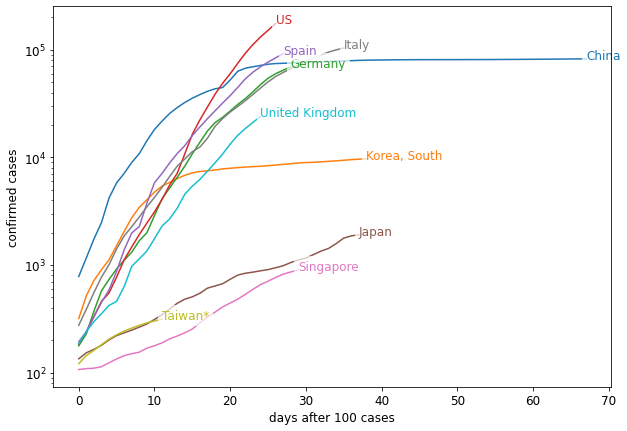

In [41]:
countries = ["China","Korea, South", "Germany", "US", "Spain", "Japan", "Singapore",
             "Italy", "Taiwan*", "United Kingdom"]
fig, ax = plt.subplots(figsize=(10, 7))
logplot(confirmed_cases, countries=countries, ax = ax,
        ylabel="confirmed cases", xlabel="days after 100 cases",
        mollifier=hard_mollifier)

Next, it is interesting to compare the growth rates instead of the total number of cases. To get a better picture whether social distancing and containment measures are working one should look at the relative growth rates $\mathrm{daily~growth} / \mathrm{infectious~cases}$ instead of the absolute growth rate $\mathrm{daily~growth} = \mathrm{cases~today} - \mathrm{cases~yesterday}$.
This is obtained by most easily by taking the derivative of the logarithm of confirmed cases and implemented in the function `exponent` (named this way, because this also gives the exponent of the "instantaneous" exponential growth). As a smoothing kernel we use the softer one this time, because the analysis involves taking derivatives.

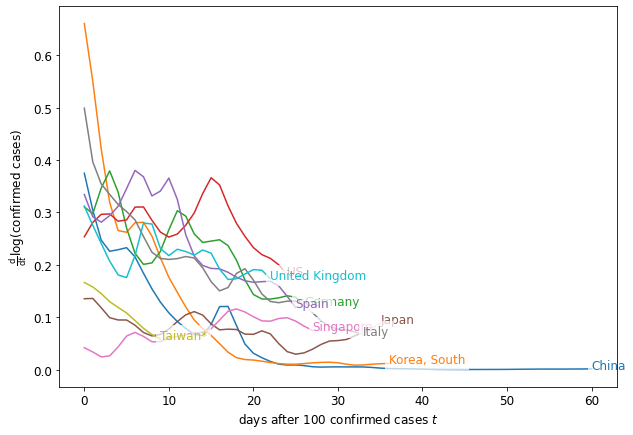

In [14]:
fig, ax = plt.subplots(figsize=(10, 7))
exponent(confirmed_cases, countries=countries, ax = ax, mollifier=soft_mollifier,
         xlabel=r"days after 100 confirmed cases $t$",
         ylabel=r"$\frac{\mathrm{d}}{\mathrm{d}t} \log (\mathrm{confirmed~cases})$")

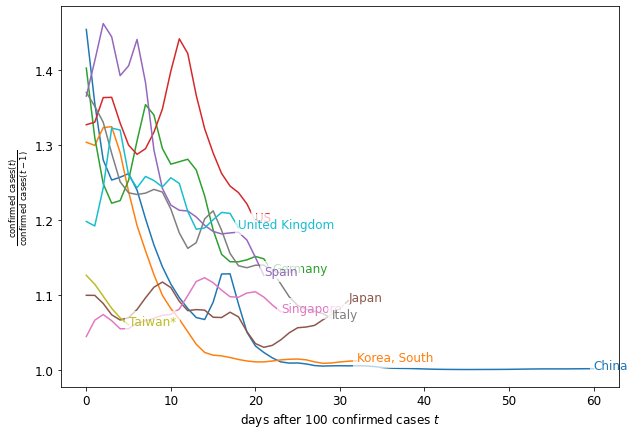

In [42]:
fig, ax = plt.subplots(figsize=(10, 7))
growthrate(confirmed_cases, countries=countries, ax = ax, mollifier=soft_mollifier,
           xlabel=r"days after 100 confirmed cases $t$",
           ylabel=r"$\frac{\mathrm{confirmed~cases}(t)}{\mathrm{confirmed~cases}(t-1)}$")

Things get even more interesting, when we don't plot agains time or days after the 100th case on the x-axis, but instead plot the number of new infections vs the number of confirmed cases.
This plot shows, at which point into the epidemic the exponential growth is stopped and the measures against it start working.
It would be, in a way, even more correct to plot the number of new infections vs the number of active cases. Feel free to adjust the code in such a way.

Text(10000.0, 20000.0, '33 % daily growth')

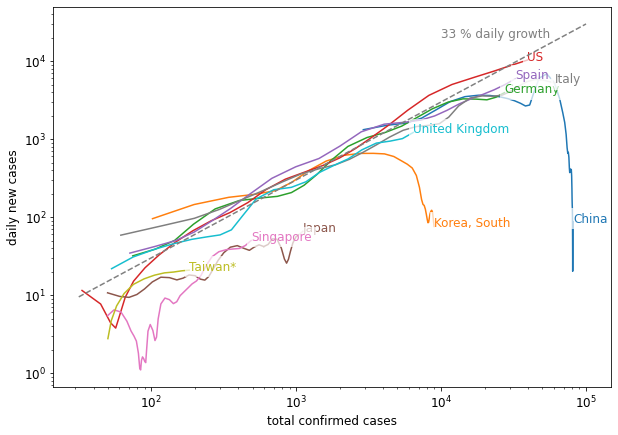

In [269]:
fig, ax = plt.subplots(figsize=(10, 7))
growthvscases(confirmed_cases, countries=countries, threshold=50, ax=ax,
              mollifier=soft_mollifier,
              xlabel="total confirmed cases", ylabel="daily new cases")
x = np.logspace(1.5, 5, num=50)
y = .3 * x
ax.plot(x, y, linestyle="--", color="grey")
ax.annotate("33 % daily growth", (1e4, 2e4), color="grey")

This time I feel the need to comment on what we see here: Except for the three east asian model countries Taiwan, Singapore and Japan all countries start off with the exactly the same exponential growth. China and South Korea are the only two countries that managed to push the eject button yet and clearly deviate from this exponential growth while in all other countries the measures taken against the spread show no effect, yet. 

Testing practices differ from country to country. This means, that the number shown in the first plot may not be directly comparable. What is much harder to ignore than slightly sick people are dead people. So in a way the case fatality (the ratio of deaths over known cases) is an indicator for how well testing is working. Note however, that not only bad testing practices result in high case fatality rates, but also hospitals that are overwhelmed by the numbers of cases. As explained earlier we implemented two different ways to measure the case fatality rates. Because neither is perfectly satisfactory, we show the results of both here. An even better way might be comparing the of deaths in a week with the number of new cases the previous week. Feel free to implement this!

(-2.0, 20.0)

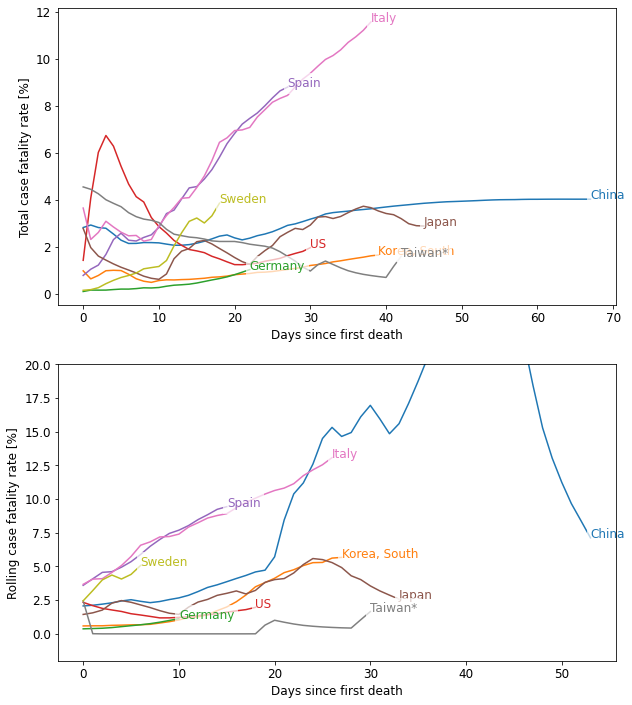

In [46]:
countries = ["China","Korea, South", "Germany", "US", "Spain", "Japan",
             "Italy", "Taiwan*", "Sweden"]
fig, ax = plt.subplots(2,1, figsize=(10, 12))
totalcasefatality(confirmed_cases, dead_cases, countries=countries, threshold=1, ax=ax[0],
                  mollifier=hard_mollifier)
rollingcasefatality(confirmed_cases, dead_cases, countries=countries, threshold=1,
                    ax=ax[1], window_width=14, mollifier=hard_mollifier)
ax[1].set_ylim(-2, 20)

An intersting thing that also shows the shortcomings of the rolling case fatality rate is the spike of it in the chinses numbers after the lockdown. This can be attributed to the fact that China didn't record any new cases within a week after the lockdown, but the old cases were still dying. So a better way to implement the rolling case fatality rate would might be to use shifted windows for the death and new case numbers. How many days one needs to shift might be found out by trying to shift the number `dead_cases` in time such that it becomes as similar as possible to the `active cases` (similar meaning: The same function up to a constant factor).